### Variante 1: StateGraph mit “parallel edges” (Fan-out → Fan-in)

In [1]:
from typing import TypedDict, Optional
from langgraph.graph import StateGraph, END
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
import nest_asyncio

nest_asyncio.apply()

class S(TypedDict, total=False):
    input: str
    b_out: str
    c_out: str
    merged: str

def node_a(state: S) -> S:
    return {"input": state["input"]}

def node_b(state: S) -> S:
    return {"b_out": f"B saw: {state['input']}"}

def node_c(state: S) -> S:
    return {"c_out": f"C saw: {state['input']}"}

def node_d(state: S) -> S:
    # Join: both b_out and c_out should exist now
    return {"merged": f"{state.get('b_out')} | {state.get('c_out')}"}

g = StateGraph(S)

g.add_node("A", node_a)
g.add_node("B", node_b)
g.add_node("C", node_c)
g.add_node("D", node_d)

g.set_entry_point("A")

# Fan-out: A -> B and A -> C
g.add_edge("A", "B")
g.add_edge("A", "C")

# Fan-in: B -> D and C -> D
# D will run once the scheduler has both paths completed.
g.add_edge("B", "D")
g.add_edge("C", "D")

g.add_edge("D", END)

graph = g.compile()

result = graph.invoke({"input": "hello"})
print(result["merged"])


B saw: hello | C saw: hello


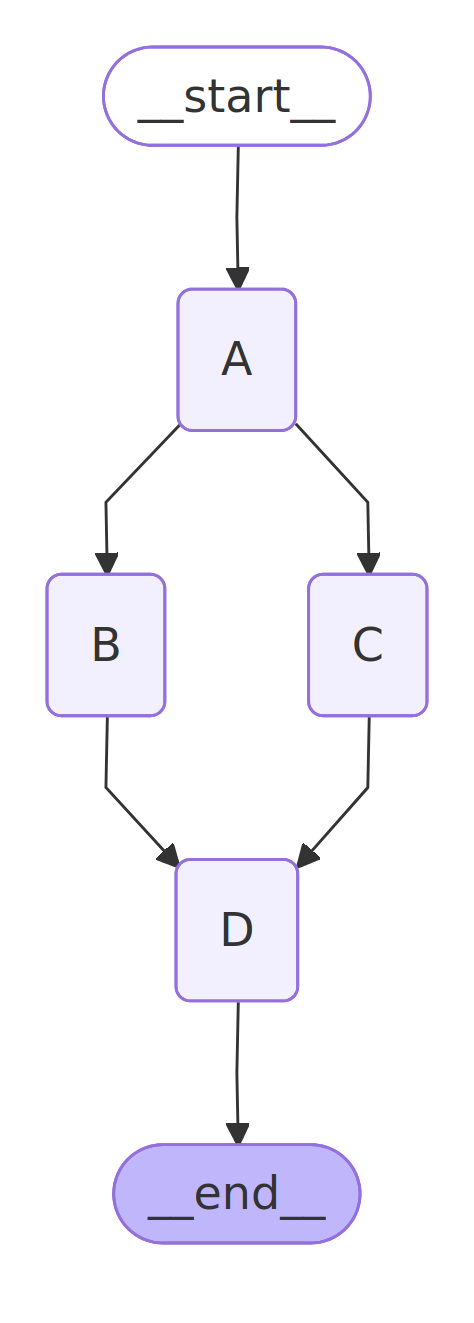

In [2]:
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.PYPPETEER
        )
    )
)

### Variante 2: Wenn du wirklich “gleichzeitig” im selben Node willst (Async in einem Knoten)

Manchmal ist’s einfacher: B und C sind nur zwei Calls (z.B. zwei Agents) und du willst die in einem Node

In [3]:
import asyncio
from typing import TypedDict
from langgraph.graph import StateGraph, END

class S(TypedDict, total=False):
    input: str
    b_out: str
    c_out: str
    merged: str

async def run_b(text: str) -> str:
    # await agent_b.ainvoke(...)
    return f"B saw: {text}"

async def run_c(text: str) -> str:
    # await agent_c.ainvoke(...)
    return f"C saw: {text}"

async def node_bc_parallel(state: S) -> S:
    b_out, c_out = await asyncio.gather(
        run_b(state["input"]),
        run_c(state["input"]),
    )
    return {"b_out": b_out, "c_out": c_out}

def node_d(state: S) -> S:
    return {"merged": f"{state['b_out']} | {state['c_out']}"}

g = StateGraph(S)
g.add_node("BC", node_bc_parallel)
g.add_node("D", node_d)

g.set_entry_point("BC")
g.add_edge("BC", "D")
g.add_edge("D", END)

graph = g.compile()
res = await graph.ainvoke({"input": "hello"})
print(res["merged"])


B saw: hello | C saw: hello


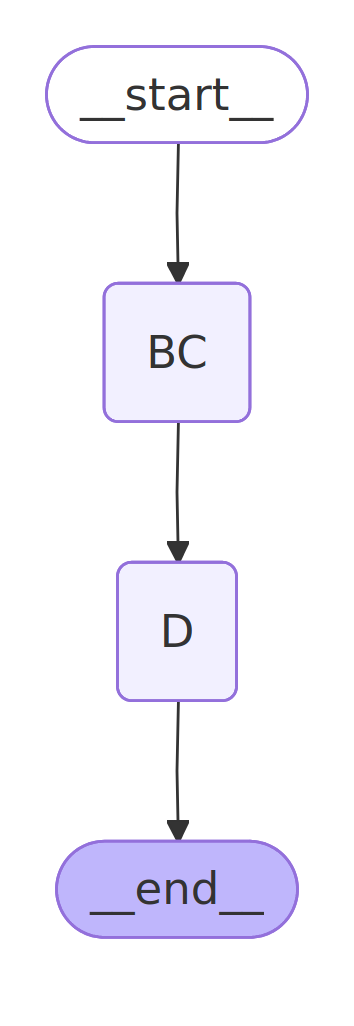

In [4]:
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.PYPPETEER
        )
    )
)


In [5]:
print(graph.get_graph().draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	BC(BC)
	D(D)
	__end__([<p>__end__</p>]):::last
	BC --> D;
	__start__ --> BC;
	D --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



### ChromaDB

In [9]:
import chromadb
from rich.pretty import Pretty
# chroma_client = chromadb.PersistentClient(path="./chroma_data")
chroma_client = chromadb.HttpClient()

# switch `create_collection` to `get_or_create_collection` to avoid creating a new collection every time
collection = chroma_client.get_or_create_collection(name="my_collection")

# switch `add` to `upsert` to avoid adding the same documents every time
collection.upsert(
    documents=[
        "This is a document about pineapple",
        "This is a document about oranges"
    ],
    ids=["id1", "id2"]
)

results = collection.query(
    query_texts=["This is a query document about florida"], # Chroma will embed this for you
    n_results=2 # how many results to return
)

Pretty(results)


{
    'ids': [['id2', 'id1']],
    'distances': [[1.1462138, 1.3015385]],
    'embeddings': None,
    'metadatas': [[None, None]],
    'documents': [['This is a document about oranges', 'This is a document about pineapple']],
    'uris': None,
    'data': None,
    'included': ['metadatas', 'documents', 'distances']
}